In [1]:
from collections import Counter

import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import helpers

C:\Users\COEGIN\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 64
num_classes = 36
epochs = 50
img_rows, img_cols = 20, 20

print('Start loading data.')
files, labels = helpers.load_chars74k_data()
X, y = helpers.create_dataset(files, labels)
print('Data has been loaded.')

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=2, train_size=0.8)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

Start loading data.
Data has been loaded.
x_train shape: (6188, 20, 20, 1)
6188 train samples
1547 test samples


C:\Users\COEGIN\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# train_generator, validation_generator = helpers.create_datagenerator(x_train, x_test, y_train, y_test)

# Convolutional network will be build with Keras.
print('Start training the model.')
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# model.fit_generator(train_generator,
#                     steps_per_epoch=10000 // batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=validation_generator,
#                     validation_steps=6000 // batch_size)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Calculate loss and accuracy.
score = model.evaluate(x_test, y_test, verbose=0)
print('Model has been trained.')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Start training the model.
Train on 6188 samples, validate on 1547 samples
Epoch 1/50
6188/6188 [==============================] - 16s 3ms/step - loss: 14.9606 - acc: 0.0642 - val_loss: 14.1367 - val_acc: 0.0950
Epoch 2/50
6188/6188 [==============================] - 17s 3ms/step - loss: 5.5801 - acc: 0.1534 - val_loss: 2.3124 - val_acc: 0.4066
Epoch 3/50
6188/6188 [==============================] - 18s 3ms/step - loss: 2.2398 - acc: 0.4156 - val_loss: 1.4976 - val_acc: 0.6005
Epoch 4/50
6188/6188 [==============================] - 18s 3ms/step - loss: 1.6201 - acc: 0.5601 - val_loss: 1.1484 - val_acc: 0.6904
Epoch 5/50
6188/6188 [==============================] - 17s 3ms/step - loss: 1.3311 - acc: 0.6336 - val_loss: 0.9792 - val_acc: 0.7369
Epoch 6/50
6188/6188 [==============================] - 17s 3ms/step - loss: 1.1397 - acc: 0.6868 - val_loss: 0.8368 - val_acc: 0.7699
Epoch 7/50
6188/6188 [==============================] - 17s 3ms/step - loss: 0.9666 - acc: 0.7293 - val_loss: 0.80

In [4]:
#Save the model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [5]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

import os
import os.path as path

MODEL_NAME = 'chars74k_convnet'
saver = tf.train.Saver()
input_node_names = ["conv2d_1_input"]
output_node_name = "dense_2/Softmax"


tf.train.write_graph(K.get_session().graph_def, 'out', \
                     MODEL_NAME + '_graph.pbtxt', as_text=True)

saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

input_graph_def = tf.GraphDef()
with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
    input_graph_def.ParseFromString(f.read())

output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
    f.write(output_graph_def.SerializeToString())

print("graph saved!")

INFO:tensorflow:Restoring parameters from out/chars74k_convnet.chkp
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
graph saved!


In [6]:
import tensorflow as tf

from keras import backend as K
from tensorflow.python.framework import graph_util
from collections import Counter

import numpy as np
import keras.models
from keras.models import model_from_json
from scipy.misc import imread, imresize,imshow
import matplotlib.pyplot as plt
%matplotlib inline
import helpers

json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load woeights into new model


K.set_learning_phase(0)
model = loaded_model.load_weights("model.h5")
sess = K.get_session()

output_node_name = "dense_2/Softmax" # Name of your output node

with sess as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    graph_def = sess.graph.as_graph_def()
    output_graph_def = graph_util.convert_variables_to_constants(
                                                                 sess,
                                                                 sess.graph.as_graph_def(),
                                                                 output_node_name.split(","))
    tf.train.write_graph(output_graph_def,
                         logdir="my_dir",
                         name="my_model.pb",
                         as_text=False)

INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.


NameError: name 'history' is not defined

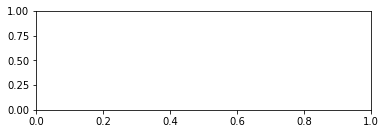

In [8]:
# print(history.history.keys())  

plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  
 
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()